In [17]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib as mpl

from skopt.space import Dimension, Real
from definitions import PROCESSED_DATA_DIR
from src.data.indicators import rsi, stochRSI, ema
from src.models.strategies import RSIStoch200EMA, BuyAndHold
from src.data.data_pipeline import split_timeseries, evaluate_performance, optimize_hyperparameters

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
btcusdt = pd.read_csv(PROCESSED_DATA_DIR / 'BTCUSDT.csv')
btcusdt.index = pd.DatetimeIndex(btcusdt['open time'])

In [4]:
#Evaluation parameters
num_iteration = 500

#Testset parameters
testset_length = 1000 #30-min intervalls
testset_start = None #random start
random_seed = 1

#Hyperparameters ...#ToDo
hyperparameter_space = [
    Real(10 ** -5, 1.25, "log-uniform", name='max_number_open_trades'),
    Real(10 ** -6, 4096, "log-uniform", name='min_period_to_last_low'), 
    Real(10 ** -6, 4096, "log-uniform", name='max_period_to_last_low'), 
    Real(10 ** -6, 4096, "log-uniform", name='min_absolute_slope_rsi'), 
    Real(10 ** -6, 4096, "log-uniform", name='swing_low_margin'),  
]
num_calls = 30

results = []

for i in range(num_iteration):
    
    result_dict = {}

    #Prepare dataset
    [test_set, training_set] = split_timeseries(btcusdt, testset_length, testset_start, i)

    #Optimize Hyperparameters
    tuned_hps = optimize_hyperparameters(training_set, hyperparameter_space, num_calls) 

    #Apply strategy with tuned hyperparameter on test set
    strategy = RSIStoch200EMA(  #ToDo
        tuned_hps['max_number_open_trades'],
        tuned_hps['min_period_to_last_low'],
        tuned_hps['max_period_to_last_low'],
        tuned_hps['min_absolute_slope_rsi'],
        tuned_hps['swing_low_margin']
    )
    result_dict['tuned_hps'] = tuned_hps

    
    result_dict['strategy_result'] = strategy.apply(
        ohlcv_timeseries=test_set,
        asset_name='BTCUSDT'
    )

    #Evaluate test set performance
    result_dict['test_set_performance'] = evaluate_performance(results[i].pnl_history)
    
    results.append(result_dict)

    
#Evaluate iterations
#ToDo

TypeError: 'NoneType' object is not subscriptable

Text(0, 0.5, 'Max Loss')

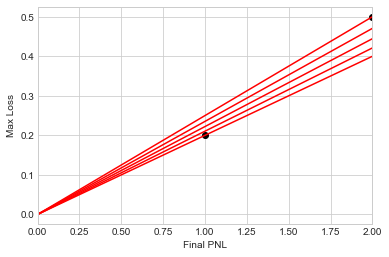

In [31]:
d1 = {'test_set_performance': {'final_pnl': 1, 'max_loss': 0.2, 'aggregate': 5}}
d2 = {'test_set_performance': {'final_pnl': 2, 'max_loss': 0.5, 'aggregate': 4}}

results = []
results.append(d1)
results.append(d2)

results

final_pnl = []
max_loss = []
aggregate = []
for res_id in range(len(results)):
    final_pnl.append(results[res_id]['test_set_performance']['final_pnl'])
    max_loss.append(results[res_id]['test_set_performance']['max_loss'])
    aggregate.append(results[res_id]['test_set_performance']['aggregate'])
    
x = np.linspace(0, max(final_pnl), 30)
y = np.linspace(0, max(max_loss), 30)
agg = np.linspace(min(aggregate), max(aggregate), 5)


mpl.pyplot.style.use('seaborn-whitegrid')
fig, ax = mpl.pyplot.subplots()
ax.margins(x=0)
ax.plot(final_pnl, max_loss, 'o', color='black')

for i in range(len(agg)):
    ax.plot(x, 1/agg[i]*x, '-', color='red')
    ax.text(max(final_pnl)*0.9, 1/agg[i]*max(final_pnl)*0.9*0.95, 'sin')
    
mpl.pyplot.xlabel("Final PNL")
mpl.pyplot.ylabel("Max Loss")

In [18]:
d1 = {'test_set_performance': {'final_pnl': 1, 'max_loss': 0.2, 'aggregate': 5}}
d2 = {'test_set_performance': {'final_pnl': 2, 'max_loss': 0.5, 'aggregate': 4}}

results = []
results.append(d1)
results.append(d2)

results

[{'test_set_performance': {'final_pnl': 1, 'max_loss': 0.2, 'aggregate': 5}},
 {'test_set_performance': {'final_pnl': 2, 'max_loss': 0.5, 'aggregate': 4}}]

In [15]:
for res_id in range(len(results)):
    results[res_id]['test_set_performance']['final_pnl']